In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Introduction to Machine Learning with Scikit-Learn

Today's workshop, which is presented by the [KAUST Visualization Core Lab (KVL)](https://corelabs.kaust.edu.sa/visualization/), is the second of two *Introduction to Machine Learning with Scikit-Learn* workshops. These workshops will largely follow Chapter 2 of [*Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow*](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) which walks through the process of developing an end-to-end machine learning project with [Scikit-Learn](https://scikit-learn.org/stable/index.html).

## Today's schedule

* Preparing the Data for Machine Learning Algorithms
* Selecting and Training a Model
* Fine Tuning Your Model

# Prepare the data for machine learning algorithms

"Best practice" is to write functions to automate the process of preparing your data for machine learning. Why?

* Allows you to reproduce these transformations easily on any dataset.
* You will gradually build a library of transformation functions that you can reuse in future projects.
* You can use these functions in a "live" system to transform the new data before feeding it to your algorithms.
* This will make it possible for you to easily experiment with various transformations and see which combination of transformations works best.

First we need to load the training data. The code below loads the training dataset that we created last week using stratified sampling on binned value of `median_income`.

In [115]:
training_df = pd.read_csv("../data/housing/training.csv", index_col="id")

In [116]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [117]:
training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
id,,,,,,,,,,
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


## Data Cleaning

We are going to start with some basic data cleaning tasks that we discussed in last week's session but that we didn't actually complete.

In [118]:
training_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000


Recall that the target variable `median_house_value` as well as attributes `housing_median_age` and `median_income` are all truncated above some threshold value.

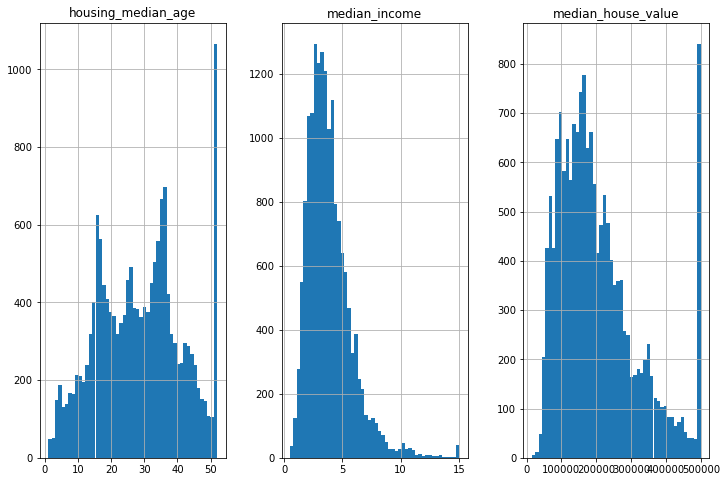

In [146]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
_ = (training_df.loc[:, ["housing_median_age", "median_income", "median_house_value"]]
                .hist(bins=50, ax=ax))


We need to drop all the observations whose values for at least one of these variables match their respective maximum values. We are also going to encapsulate the logic for dropping observations in a function so that we can reuse the same logic later to drop values from the testing data.

In [154]:
def _drop_max_values(df, attribute):
    threshold = (df.loc[:, attribute]
                   .max())
    return df.loc[df.loc[:, attribute] < threshold, :]


def drop_max_values(df):
    """
    * Median house values were truncated at 500000 USD. Census block groups with median house values 
      equal to this threshold should be excluded from the analysis.
    * Median income values were truncated at 15 (thousand USD). Census block groups with median income
      values equal to this threshold should be excluded from the analysis.
    * Median housing ages were truncated at 52 years. Census block groups with housing median age 
      values equal to this threshold should be excluded from the analysis.
    
    """
    _df = _drop_max_values(df, "median_house_value")
    _df = _drop_max_values(_df, "median_income")
    _df = _drop_max_values(_df, "housing_median_age")
    return _df


In [155]:
cleaned_training_df = drop_max_values(training_df)

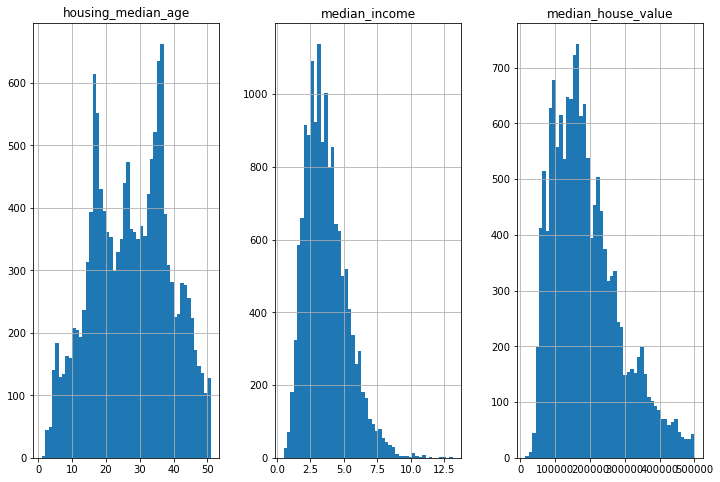

In [156]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
_ = (cleaned_training_df.loc[:, ["housing_median_age", "median_income", "median_house_value"]]
                        .hist(bins=50, ax=ax))


Let’s also separate the attributes/features and the labels/targets. Separating the attributes/features from the labels/targets allows us to more easily apply different sets of transformations to these datasets.

In [153]:
training_features_df = cleaned_training_df.drop("median_house_value", axis=1)
training_target_df = cleaned_training_df.loc[:, ["median_house_value"]]

Most machine learning algorithms will not work with missing data. There are three options for dealing with missing data.

1. Drop any training samples that are missing values for *any* attribute/feature.
2. Drop any attribute/feature with missing values.
3. Explicitly decide how to fill in the missing values.

We can implement any of the above approaches using built-in functionality of Pandas.

In [23]:
# option 1
(training_features_df.dropna(subset=["total_bedrooms"])
                     .info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16354 entries, 0 to 16511
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  16354 non-null  int64  
 1   longitude           16354 non-null  float64
 2   latitude            16354 non-null  float64
 3   housing_median_age  16354 non-null  float64
 4   total_rooms         16354 non-null  float64
 5   total_bedrooms      16354 non-null  float64
 6   population          16354 non-null  float64
 7   households          16354 non-null  float64
 8   median_income       16354 non-null  float64
 9   ocean_proximity     16354 non-null  object 
dtypes: float64(8), int64(1), object(1)
memory usage: 1.4+ MB


In [24]:
# option 2
(training_features_df.drop("total_bedrooms", axis=1)
                     .info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  16512 non-null  int64  
 1   longitude           16512 non-null  float64
 2   latitude            16512 non-null  float64
 3   housing_median_age  16512 non-null  float64
 4   total_rooms         16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(7), int64(1), object(1)
memory usage: 1.1+ MB


In [25]:
# option 3
_median = (training_features_df.loc[:, "total_bedrooms"] # save this value for later so you can prepare the testing features!
                               .median())
(training_features_df.fillna({"total_bedrooms": _median})
                     .info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  16512 non-null  int64  
 1   longitude           16512 non-null  float64
 2   latitude            16512 non-null  float64
 3   housing_median_age  16512 non-null  float64
 4   total_rooms         16512 non-null  float64
 5   total_bedrooms      16512 non-null  float64
 6   population          16512 non-null  float64
 7   households          16512 non-null  float64
 8   median_income       16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


However, rather than using Pandas I recommend using the Scikit-Learn. The Scikit-Learn [`impute`](https://scikit-learn.org/stable/modules/impute.html) module contains a number of different algorithms for filling missing values.  

In [26]:
from sklearn import impute


simple_imputer = impute.SimpleImputer(strategy="median")

In [27]:
simple_imputer.fit(training_features_df)

ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: '<1H OCEAN'

Since the median only exists for numeric atttributes/features, you will need to drop all of the non-numeric attributes/features from the dataset before fitting `simple_imputer`.

In [31]:
numeric_features_df = training_features_df.drop("ocean_proximity", axis=1)
simple_imputer.fit(numeric_features_df)

SimpleImputer(strategy='median')

Fitting the `simple_impute` will compute the median values for each attribute/feature in the dataset and store the values for later reuse. 

In [32]:
simple_imputer.statistics_

array([ 1.0341e+04, -1.1851e+02,  3.4260e+01,  2.9000e+01,  2.1195e+03,
        4.3300e+02,  1.1640e+03,  4.0800e+02,  3.5409e+00])

In [44]:
# medians computed using Pandas give same results as above
numeric_features_df.median()

id                    10341.0000
longitude              -118.5100
latitude                 34.2600
housing_median_age       29.0000
total_rooms            2119.5000
total_bedrooms          433.0000
population             1164.0000
households              408.0000
median_income             3.5409
dtype: float64

To fill any missing value in the original dataset using the median values computed by calling the `fit` method, we call the `tranform` method.

In [84]:
imputed_numeric_features_df = simple_imputer.transform(numeric_features_df)

In [85]:
# Z is numpy array and no longer has any missing values
np.any(imputed_numeric_features_df == np.nan)

False

There is also a `fit_transform` method which combines the calls to `fit` and `transform` in sequence.

In [86]:
imputed_numeric_features_df = simple_imputer.fit_transform(numeric_features_df)

In [49]:
simple_imputer.statistics_

array([ 1.0341e+04, -1.1851e+02,  3.4260e+01,  2.9000e+01,  2.1195e+03,
        4.3300e+02,  1.1640e+03,  4.0800e+02,  3.5409e+00])

## Handling Text and Categorical Attributes

So far we have only discussed how to handle numeric attributes/features. Our dataset contains on non-numeric attribute/feature, `ocean_proximity` which we have good reason to think is important determinant of housing prices.

In [50]:
non_numeric_features_df = training_features_df.loc[:, ["ocean_proximity"]]

In [51]:
non_numeric_features_df.head()

,ocean_proximity
0,<1H OCEAN
1,<1H OCEAN
2,NEAR OCEAN
3,INLAND
4,<1H OCEAN


While the above might look like arbitrary text, `ocean_proximity` only takes a limited number of values.

In [52]:
non_numeric_features_df.value_counts()

ocean_proximity
<1H OCEAN          7276
INLAND             5263
NEAR OCEAN         2124
NEAR BAY           1847
ISLAND                2
dtype: int64

Machine learning algorithms almost always work with numbers. The Scikit-Learn [`preprocessing`](https://scikit-learn.org/stable/modules/preprocessing.html) module has several strategies for [encoding non-numeric attributes/features](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features). The simplest strategy is called ordinal encoding and is implemented by the [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) class.

In [75]:
ordinal_encoder = preprocessing.OrdinalEncoder()

In [60]:
Z1 = ordinal_encoder.fit_transform(non_numeric_features_df)

In [61]:
Z1

array([[0.],
       [0.],
       [4.],
       ...,
       [1.],
       [0.],
       [3.]])

In [62]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

With this representation machine learning algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases, for example cases where the the categories have a natural ordering such as “bad,” “average,” “good,” and “excellent”. 

### Exercise

Can anyone see an issue with using an ordinal encoding for our `ocean_proximity` attribute?

### Answer:

The categories for `ocean_proximity` are not obviously ordered. For example category `0` (`<1H Ocean`) and category `4` (`NEAR OCEAN`) are cleary more similar than to categories `1` and `3`, respectively. Also what about the category `3` (`ISLAND`)?

An alternative encoding strategy that is commonly used with categorical features that have not natural ordering is to create one binary attribute per category. In our case we create one attribute equal to `1` when the category is `<1H OCEAN` (and `0` otherwise), another attribute equal to `1` when the category is `INLAND` (and `0` otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). These new attributes are sometimes called dummy attributes. Scikit-Learn provides a [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) class to convert categorical values into one-hot vectors.

In [55]:
Z2 = one_hot_encoder.fit_transform(non_numeric_features_df)

In [56]:
# transformed features are now a sparse matrix
Z2

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [57]:
# convert sparse matrix to dense numpy array 
Z2.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [63]:
one_hot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Note that if a categorical attribute has a large number of possible categories, then one-hot encoding will result in a large number of input features. This may slow down training and degrade performance. If this happens, you may want to try replacing the categorical attributes/features with useful numerical attributes/features related to the categories: for example, you could replace the `ocean_proximity` feature with the distance to the ocean. Alternatively, you could replace each category with a learnable, low-dimensional vector called an embedding. This approach is called [feature learning](https://en.wikipedia.org/wiki/Feature_learning) or representation learning and is covered in chapters 13 and 17 of textbook).

## Feature Scaling

Machine learning algorithms typically don’t perform well when the input numerical attributes have very different scales.

In [66]:
training_features_df.describe()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000
mean,10332.352108,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589
std,5979.473431,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950
min,0.000000,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,5157.750000,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775
50%,10341.000000,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900
75%,15522.500000,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475
max,20638.000000,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


The simplest approach is to rescale features so that they all reside within the same range (typically between 0 and 1). This approach is implemented in Scikit-Learn by the [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) class.

In [77]:
min_max_scaler = preprocessing.MinMaxScaler()

In [87]:
scaled_numeric_features_df = min_max_scaler.fit_transform(imputed_numeric_features_df)

In [88]:
min_max_scaler.data_min_ # these values will be reused later to rescale the testing features

array([   0.    , -124.35  ,   32.54  ,    1.    ,    6.    ,    2.    ,
          3.    ,    2.    ,    0.4999])

In [89]:
min_max_scaler.data_max_ # these values will be reused later to rescale the testing features

array([ 2.06380e+04, -1.14310e+02,  4.19500e+01,  5.20000e+01,
        3.93200e+04,  6.21000e+03,  3.56820e+04,  5.35800e+03,
        1.50001e+01])

But what happens if an attribute has outliers and you apply min-max scaling?

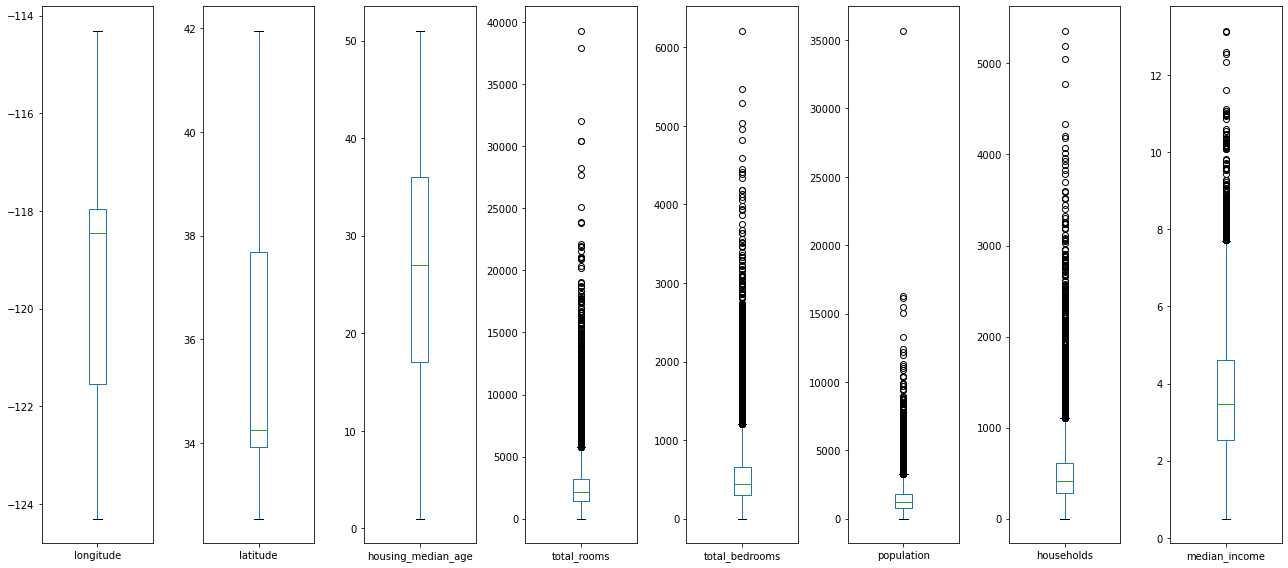

In [164]:
_ = training_features_df.plot(kind="box", subplots=True, figsize=(18, 8))
plt.tight_layout()

An alternative approach is to rescale features so that they all have zero mean and unit standard deviation. This approach, which is also called standardization, is particularly useful when attributes/features have outliers and when downstream machine learning algorithms assume that attributes/features have a Gaussian or Normal distribution.

In [91]:
# we will use this to make sure that all numerical features have the same scale
standard_scaler = preprocessing.StandardScaler()

In [92]:
scaled_numeric_features_df = standard_scaler.fit_transform(imputed_numeric_features_df)

In [95]:
standard_scaler.mean_ # these values will be reused later to rescale the testing features

array([ 1.03323521e+04, -1.19575834e+02,  3.56395773e+01,  2.86531008e+01,
        2.62272832e+03,  5.33998123e+02,  1.41979082e+03,  4.97060380e+02,
        3.87558937e+00])

In [94]:
standard_scaler.scale_ # these values will be reused later to rescale the testing features

array([5.97929236e+03, 2.00179963e+00, 2.13799280e+00, 1.25743452e+01,
       2.13839366e+03, 4.10827180e+02, 1.11565246e+03, 3.75709468e+02,
       1.90489191e+00])

As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (including the test set). Only then can you use them to transform the training set and the test set (and new data).

## Transformation Pipelines

As you can see creating preprocessing pipelines involves quite a lot of steps and each of the steps needs to be executed in the correct order. Fortunately Scikit-Learn allows you to combine estimators together to create [pipelines](https://scikit-learn.org/stable/modules/compose.html#combining-estimators). We can encapsulate all of the preprocessing logic for our numeric attributes as well as the preprocessing logic for our non-numeric attributes into separate instances of the [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) class.

The `Pipeline` constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a `fit_transform` method). The names can be anything you like (as long as they are unique). Later we will see how to access the parameters of pipelines using these names when we discuss hyperparameter tuning.

In [96]:
from sklearn import pipeline


numerical_pipeline = pipeline.Pipeline(
    steps=[
        ('imputer', impute.SimpleImputer(strategy="median")),
        ('standard_scaler', preprocessing.StandardScaler())
    ],
)

categorical_pipeline = pipeline.Pipeline(
    steps=[
        ("one_hot_encoder", preprocessing.OneHotEncoder())
    ],
)

We can then [combine these pipelines](https://scikit-learn.org/stable/modules/compose.html#columntransformer-for-heterogeneous-data) into a single pipeline using the [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer) class. The constructor requires a list of tuples, where each tuple contains a name, a transformer, and a list of names (or indices) of columns that the transformer should be applied to. 

In [97]:
from sklearn import compose


numerical_attributes = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income"
]

categorical_attributes = [
    "ocean_proximity"
]

preprocessing_pipeline = compose.ColumnTransformer(
    transformers=[
        ("numerical_pipeline", numerical_pipeline, numerical_attributes),
        ("categorical_pipeline", categorical_pipeline, categorical_attributes)
    ],
)

Now we can fit the entire preprocessing pipeline to our training features dataset in one go!

In [166]:
preprocessed_training_features = preprocessing_pipeline.fit_transform(training_features_df)

In [251]:
type(preprocessed_training_features)

numpy.ndarray

I often find it useful to create a Pandas `DataFrame` from the `preprocessed_training_features` NumPy `ndarray`.

In [263]:
categories = list(preprocessing_pipeline.named_transformers_["categorical_pipeline"]
                                        .named_steps["one_hot_encoder"]
                                        .categories_[0])

_columns = numerical_attributes + categories
preprocessed_training_features_df = (pd.DataFrame
                                       .from_records(preprocessed_training_features, columns=_columns))

In [264]:
preprocessed_training_features_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-1.215044,0.787088,0.966887,-0.499188,-0.461210,-0.659770,-0.436733,-0.629947,1.0,0.0,0.0,0.0,0.0
1,-1.235264,0.675474,-1.136845,-0.907095,-1.039427,-1.012283,-1.024709,1.745895,1.0,0.0,0.0,0.0,0.0
2,1.155790,-1.314984,0.353298,-0.322994,-0.175671,-0.462573,-0.116729,-0.529026,0.0,0.0,0.0,0.0,1.0
3,-0.062485,0.331329,-0.172635,-0.371172,-0.413620,-0.005353,-0.400310,-1.154241,0.0,1.0,0.0,0.0,0.0
4,0.453133,-0.635996,-0.873879,1.806015,2.332313,2.611443,2.487536,-0.418709,1.0,0.0,0.0,0.0,0.0


Another useful class is [`FeatureUnion`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion). `FeatureUnion` combines several transformer objects into a new transformer that combines their output. A `FeatureUnion` takes a list of transformer objects. During fitting, each of these transformers is fit to the data independently. The transformers are applied in parallel, and the feature matrices they output are concatenated side-by-side into a larger matrix.

Finally, estimators can be displayed with a HTML representation when shown in a Jupyter notebook. Visualizing estimators is particularly useful to diagnose or visualize a `Pipeline` with many estimators. This visualization is activated by setting the display option in [sklearn.set_config](https://scikit-learn.org/stable/modules/generated/sklearn.set_config.html#sklearn.set_config).

In [99]:
from sklearn import set_config

set_config(display='diagram') 

In [100]:
preprocessing_pipeline

ColumnTransformer(transformers=[('numerical_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standard_scaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('categorical_pipeline',
                                 Pipeline(steps=[('one_hot_encoder',
                                                  OneHotEncoder())]),
                                 ['ocean_proximity'])])

# Select and Train a Model

At last! You framed the problem, you got the data and explored it, you sampled a training set and a test set, and you wrote transformation pipelines to clean up and prepare your data for machine learning algorithms automatically. You are now ready to select and train a Machine Learning model. You might have been wondering if we were every going to make it to this point! Fact is, most of your time developing machine learning solutions to real-world problems will not be spent training machine learning models: most of *your* time will be spent preparing the data for machine learning algorithms and most of the *computer* time will be spent training the machine learning models.

## Training and Evaluating on the Training Dataset

In [167]:
from sklearn import linear_model


regressor = linear_model.LinearRegression()
regressor.fit(preprocessed_training_features, training_target_df)

LinearRegression()

Congrats! You have fit your first machine learning model using Scikit-Learn. Now let's evaluate our model's performance using our chosen metric: root mean squared error (RMSE).

In [172]:
from sklearn import metrics


predictions = regressor.predict(preprocessed_training_features)
mse = metrics.mean_squared_error(training_target_df, predictions)
rmse = mse**0.5

In [173]:
rmse # units are USD

59061.77494806611

In [175]:
from sklearn import tree


regressor = tree.DecisionTreeRegressor()
regressor.fit(preprocessed_training_features, training_target_df)

DecisionTreeRegressor()

In [176]:
predictions = regressor.predict(preprocessed_training_features)
mse = metrics.mean_squared_error(training_target_df, predictions)
rmse = mse**0.5

In [177]:
rmse

0.0

Wait, what!? No error at all? Could this model really be absolutely perfect? Unfortunately it is much more likely that the model has badly overfit the training data. How can you be sure? As we saw earlier, you don’t want to touch the testing dataset until you are ready to launch a model you are confident about, so you need to use part of the training set for training and part of it for model validation.

## Better Evaluation using Cross Validation

In [180]:
from sklearn import model_selection


linear_regression_scores = model_selection.cross_val_score(linear_model.LinearRegression(),
                                                           X=preprocessed_training_features,
                                                           y=training_target_df,
                                                           cv=10,
                                                           scoring="neg_mean_squared_error",
                                                           n_jobs=10)

In [191]:
def display_rmses(rmses):
    print("RMSE mean:", rmses.mean())
    print("RMSE standard deviation:", rmses.std())


In [192]:
linear_regression_rmses = np.sqrt(-linear_regression_scores)
display_rmses(linear_regression_rmses)

RMSE mean: 59232.03721879772
RMSE standard deviation: 2062.417177066079


In [193]:
_random_state = np.random.RandomState(42)
decision_tree_scores = model_selection.cross_val_score(tree.DecisionTreeRegressor(random_state=_random_state),
                                                       X=preprocessed_training_features,
                                                       y=training_target_df,
                                                       cv=10,
                                                       scoring="neg_mean_squared_error",
                                                       n_jobs=10)

In [194]:
decision_tree_rmses = np.sqrt(-decision_tree_scores)
display_rmses(decision_tree_rmses)

RMSE mean: 62665.694990120886
RMSE standard deviation: 1216.8029318152537


Now the `DecisionTreeRegressor` doesn’t look nearly as good as it did earlier. In fact, it seems to perform worse than the much simpler `LinearRegression` model. Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation).

Let’s try one last model now: the [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). Random forests work by training many decision trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called [ensemble learning](https://en.wikipedia.org/wiki/Ensemble_learning) and it is often a great approach to improve the predictions of your machine learning pipeline.

In [201]:
from sklearn import ensemble


_random_state = np.random.RandomState(42)
regressor = ensemble.RandomForestRegressor(random_state=_random_state)
regressor.fit(preprocessed_training_features, training_target_df.iloc[:, 0].ravel())

RandomForestRegressor(random_state=RandomState(MT19937) at 0x7F8EDB8EA840)

In [199]:
predictions = regressor.predict(preprocessed_training_features)
mse = metrics.mean_squared_error(training_target_df, predictions)
rmse = mse**0.5

In [200]:
rmse

16465.81787480853

In [186]:
_random_state = np.random.RandomState(42)
random_forest_scores = model_selection.cross_val_score(ensemble.RandomForestRegressor(random_state=_random_state),
                                                       X=preprocessed_training_features,
                                                       y=training_target_df,
                                                       cv=10,
                                                       scoring="neg_mean_squared_error",
                                                       n_jobs=10)

In [195]:
random_forest_rmses = np.sqrt(-random_forest_scores)
display_rmses(random_forest_rmses)

RMSE mean: 44438.288762901655
RMSE standard deviation: 1116.500895018986


A `RandomForestRegressor` look very promising. Note that the score on the training set is still much lower than on the validation sets which indicates that this model is still overfitting the training set. Possible solutions for overfitting are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data.

### Exercise

Before we dive into hyperparameter tuning, you should out a few other models from various categories of machine Learning algorithms: in particular take a look at [Nearest Neighbor](https://scikit-learn.org/stable/modules/neighbors.html) and [Support Vector Machine (SVM)](https://scikit-learn.org/stable/modules/svm.html#regression) regression algorithms. Don't spend too much time tweaking the default hyperparameters. The goal is to shortlist two or three promising models for fine-tuning.

In [203]:
from sklearn import neighbors

In [207]:
knn_scores = model_selection.cross_val_score(neighbors.KNeighborsRegressor(),
                                                       X=preprocessed_training_features,
                                                       y=training_target_df,
                                                       cv=10,
                                                       scoring="neg_mean_squared_error",
                                                       n_jobs=10)

In [208]:
knn_rmses = np.sqrt(-knn_scores)
display_rmses(knn_rmses)

RMSE mean: 54469.436639022584
RMSE standard deviation: 1146.2039812228186


In [210]:
from sklearn import svm

In [211]:
svr_scores = model_selection.cross_val_score(svm.SVR(),
                                             X=preprocessed_training_features,
                                             y=training_target_df,
                                             cv=10,
                                             scoring="neg_mean_squared_error",
                                             n_jobs=10)

In [212]:
svr_rmses = np.sqrt(-svr_scores)
display_rmses(svr_rmses)

RMSE mean: 97217.2346118485
RMSE standard deviation: 2414.0998010814124


# Fine-tune your models

Most common approach to tuning a model is to manually fiddle with the hyperparameters until you find a great combination of hyperparameter values. Needless to day, this approach to model tuning is *very* tedious and not at all scientific. We can do much better!

## Grid Search

Simplest approach is to use Scikit-Learn’s [`model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). All you need to do is tell it which hyperparameters you want it to experiment with and what values to try out. The `model_selection.GridSearchCV` class will then use cross-validation to evaluate all the possible combinations of hyperparameter values and return the best scoring set of hyperparameters according to your specified metric.

In [218]:
parameter_grid = [
    {'n_estimators': [10, 100], 'max_features': ["auto", "sqrt", "log2"]}, # 2 * 3 = 6 parameter combinations to try
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 4, 8]}, # 1 * 2 * 3 = 6 parameter combinations to try
]

_random_state = np.random.RandomState(42)
random_forest_regressor = ensemble.RandomForestRegressor(random_state=_random_state)

grid_search_cv = model_selection.GridSearchCV(random_forest_regressor,
                                              parameter_grid,
                                              cv=5,
                                              scoring='neg_mean_squared_error',
                                              return_train_score=True,
                                              n_jobs=5,
                                              verbose=10)

grid_search_cv

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(random_state=RandomState(MT19937) at 0x7F8EDD9DC740),
             n_jobs=5,
             param_grid=[{'max_features': ['auto', 'sqrt', 'log2'],
                          'n_estimators': [10, 100]},
                         {'bootstrap': [False], 'max_features': [2, 4, 8],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=10)

In [219]:
_ = grid_search_cv.fit(preprocessed_training_features, training_target_df)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    8.7s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    9.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   12.2s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   15.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   15.5s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:   16.4s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:   17.3s remaining:    0.6s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:   17.4s finished
/Users/drpugh/Training/kaust-vislab/introduction-to-ml-with-sklearn/env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(random_state=RandomState(MT19937) at 0x7F8EDD9DC740),
             n_jobs=5,
             param_grid=[{'max_features': ['auto', 'sqrt', 'log2'],
                          'n_estimators': [10, 100]},
                         {'bootstrap': [False], 'max_features': [2, 4, 8],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=10)

In [220]:
grid_search_cv.best_params_

{'max_features': 'auto', 'n_estimators': 100}

In [228]:
# best_estimator_ is trained with the values from best_params_
grid_search_cv.best_estimator_

RandomForestRegressor(random_state=RandomState(MT19937) at 0x7F8EDD9DC340)

You should save every model you experiment with so that you can come back easily to any model you want. Make sure you save both the hyperparameters and the trained parameters as well as the cross-validation scores and perhaps the actual predictions as well. This will allow you to more easily compare scores across model types and compare the types of errors they make. 

In [224]:
import joblib
import time

_timestamp = time.strftime("%Y%m%d-%H%M%S")
_ = joblib.dump(grid_search_cv, f"../results/models/grid-search-cv-random-forest-regressor-{_timestamp}.pkl")

For reference here is how you would reload the trained model from the file.

In [226]:
reloaded_grid_search_cv = joblib.load("../results/models/grid-search-cv-random-forest-regressor-20201111-142446.pkl")

In [227]:
# compare with grid_search_cv.best_params_
reloaded_grid_search_cv.best_params_

{'max_features': 'auto', 'n_estimators': 100}

## Randomized Search

The grid search approach is fine when you are exploring relatively few combinations but when the hyperparameter search space is large it is often preferable to use [`model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV) instead. Instead of trying out all possible combinations, `model_selection.RandomizedSearchCV` evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits.

* More efficient exploration of the hyperparameter space.
* More control over the computing budget you want to allocate to hyperparameter search.


In [222]:
from scipy import stats


_param_distributions = {
    "n_estimators": stats.geom(p=0.01),
    "min_samples_split": stats.beta(a=1, b=99),
    "min_samples_leaf": stats.beta(a=1, b=999),
}

_random_state = np.random.RandomState(42)
random_forest_regressor = ensemble.RandomForestRegressor(random_state=_random_state)

randomized_search_cv = model_selection.RandomizedSearchCV(
    random_forest_regressor,
    param_distributions=_param_distributions,
    scoring="neg_mean_squared_error",
    random_state=_prng,
    n_iter=10,
    cv=5,
    n_jobs=5,
    verbose=10
)

randomized_search_cv

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(random_state=RandomState(MT19937) at 0x7F8EDD9DCB40),
                   n_jobs=5,
                   param_distributions={'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8ef80d2760>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8edaae3310>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8edc8f2910>},
                   random_state=RandomState(MT19937) at 0x7F8EDB217E40,
                   scoring='neg_mean_squared_error', verbose=10)

In [223]:
_ = randomized_search_cv.fit(preprocessed_training_features, training_target_df)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    9.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   12.1s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   13.6s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   14.9s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   18.8s
[Parallel(n_jobs=5)]: Done  47 out of  50 | elapsed:   23.1s remaining:    1.5s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   23.1s finished
/Users/drpugh/Training/kaust-vislab/introduction-to-ml-with-sklearn/env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [304]:
# RMSE for the best parameters
(-randomized_search_cv.best_score_)**0.5

45171.78212608899

In [40]:
randomized_search_cv.best_params_

{'min_samples_leaf': 0.00012201597570394589,
 'min_samples_split': 0.0006038819178630597,
 'n_estimators': 40}

In [41]:
_timestamp = time.strftime("%Y%m%d-%H%M%S")
_ = joblib.dump(grid_search_cv.best_estimator_, f"../results/models/randomized-search-cv-random-forest-regressor-{_timestamp}.pkl")

## Analyze the Best Models and Their Errors 

You will often gain good insights on the problem by inspecting the best models. For example, the `ensemble.RandomForestRegressor` can indicate the relative importance of each attribute for making accurate predictions.

In [267]:
_data = (randomized_search_cv.best_estimator_
                             .feature_importances_)
_index = preprocessed_training_features_df.columns
feature_importances = pd.Series(_data, index=_index)

In [270]:
feature_importances.sort_values(ascending=False)

median_income         0.468904
INLAND                0.169804
longitude             0.113814
latitude              0.108844
housing_median_age    0.038277
population            0.030338
total_rooms           0.023129
total_bedrooms        0.019214
households            0.015804
NEAR OCEAN            0.008117
<1H OCEAN             0.003090
NEAR BAY              0.000665
ISLAND                0.000000
dtype: float64

It looks like only one of the categories of `ocean_proximity` is useful. Based on this information, I might go back and re-encode `ocean_proximity` to be a binary indicator that takes the value of `1` if the category is either `ISLAND`, `NEAR_BAY`, or `NEAR OCEAN` and `0` if the value is `INLAND`. The would reduce the number of features and speed up computation for some machine learning models.

You should also look at the specific errors that your system makes, then try to understand why it makes them and what could fix the problem (adding extra features or getting rid of uninformative ones, cleaning up outliers, etc.).

In [276]:
_y_true = (training_target_df.values
                             .ravel())
_y_pred = (randomized_search_cv.best_estimator_
                               .predict(preprocessed_training_features))
_prediction_errors = _y_true - _y_pred
preprocessed_training_features_df["prediction_errors"] = _prediction_errors

### Prediction errors have lots of outliers

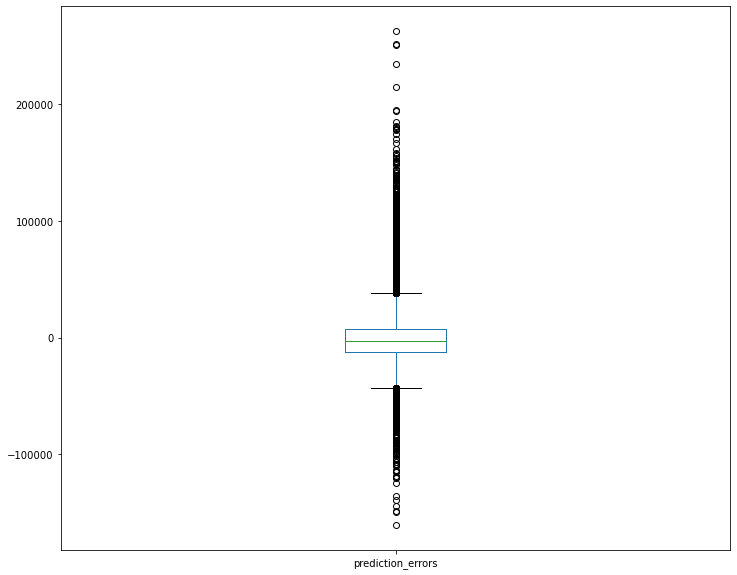

In [296]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
_ = preprocessed_training_features_df.loc[:, "prediction_errors"].plot(kind="box")

### Exploring the geographical distribution of prediction errors

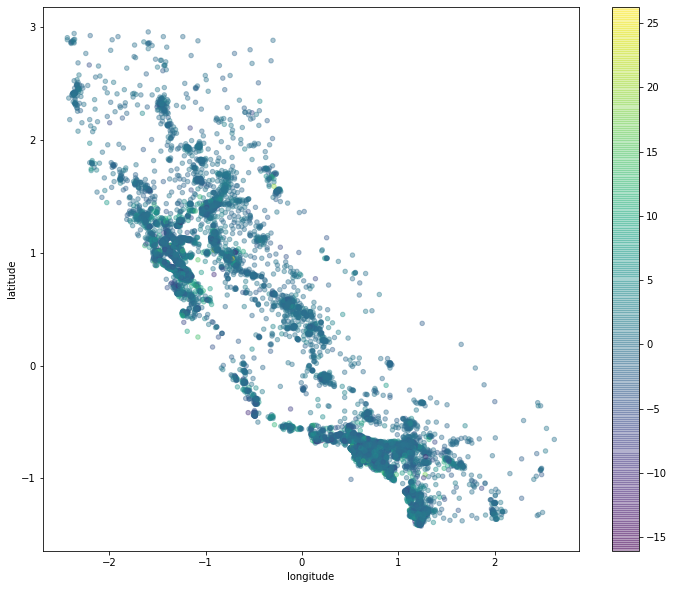

In [287]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
_color = preprocessed_training_features_df.loc[:, "prediction_errors"] / 10000
_cmap = plt.get_cmap("viridis")
_ = preprocessed_training_features_df.plot(kind="scatter", x="longitude", y="latitude", c=_color, cmap=_cmap, ax=ax, alpha=0.4)

### Exploring how prediction errors vary with median income

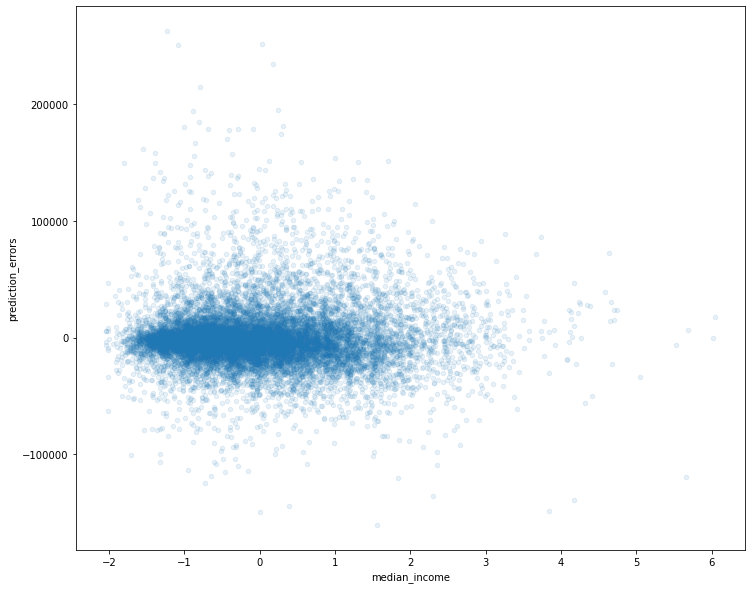

In [293]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
_ = preprocessed_training_features_df.plot(kind="scatter", x="median_income", y="prediction_errors", ax=ax, alpha=0.1)

## Evaluate your system on the test dataset

After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set.

In [298]:
testing_df = pd.read_csv("../data/housing/testing.csv", index_col="id")

In [299]:
cleaned_testing_df = drop_max_values(testing_df)
testing_features_df = cleaned_testing_df.drop("median_house_value", axis=1, inplace=False)
testing_target_df = cleaned_testing_df.loc[:, "median_house_value"]
preprocessed_testing_features = preprocessing_pipeline.transform(testing_features_df)

In [301]:
predictions = randomized_search_cv.best_estimator_.predict(preprocessed_testing_features)
np.sqrt(metrics.mean_squared_error(testing_target_df, predictions))

43183.83217977621

In some cases, such a point estimate of the generalization error will not be quite enough to convince you to launch: what if it is just marginally better than the model currently in production? You might want to have an idea of how precise this estimate is. 

In [302]:
# example of computing an estimate of the confidence interval for the test set error
confidence = 0.95
squared_errors = (testing_target_df - predictions)** 2
_interval = (stats.t
                  .interval(confidence,
                            squared_errors.size - 1,
                            loc=squared_errors.mean(),
                            scale=stats.sem(squared_errors)))
np.sqrt(_interval)

array([41240.00972629, 45043.84887237])

If you did a lot of hyperparameter tuning, the performance will usually be slightly worse than what you measured using cross-validation (because your system ends up fine-tuned to perform well on the validation data and will likely not perform as well on unknown datasets). It is not the case in this example, but when this happens you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data.